In [ ]:
import os
import cv2
import torch
import random
import subprocess
import numpy as np
from PIL import Image
import tensorflow as tf
from base64 import b64encode
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import HTML
from keras.models import model_from_json
from keras.utils.vis_utils import plot_model

plt.style.use("seaborn-v0_8-dark")

%matplotlib inline

## Configurations

In [ ]:
# Connect to google drive (where the folders are)
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Optional if you are using a local GPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# Optional if you are using the Colab GPU
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [ ]:
############################################### MoBiLSTM model parameters ###############################################################################
CLASSES_LIST = ["NonViolence","Violence"]

IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64  # Specify the height and width to which each video frame will be resized in our dataset
SEQUENCE_LENGTH = 16  # Specify the number of frames of a video that will be fed to the model as one sequence

VIOLENCE_MODEL_WEIGHTS_PATH = r"/content/gdrive/MyDrive/violence_detection/MoBiLSTM_model_weights.h5"
VIOLENCE_MODEL_ARCHITECTURE_PATH = r"/content/gdrive/MyDrive/violence_detection/MoBiLSTM_model_architecture.json"


############################################# Darknet YOLOv7 model parameters ############################################################################
DARKNET_DIR = "/content/darknet"

WEAPON_MODEL_META_PATH = r"/content/gdrive/MyDrive/weapon_detection/obj.data"
WEAPON_MODEL_CONFIG_PATH = r"/content/gdrive/MyDrive/weapon_detection/yolov7_custom.cfg"
WEAPON_MODEL_WEIGHTS_PATH = r"/content/gdrive/MyDrive/weapon_detection/yolov7_custom_best.weights"

In [ ]:
# To Show a Video in Notebook
def play_video(filepath):
    # Verify the file's extention
    _, extension = os.path.splitext(filepath)

    if extension.lower() == '.avi':
        # Open .avi video
        html = ''
        video = open(filepath, 'rb').read()
        src = 'data:video/avi;base64,' + b64encode(video).decode()
        html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/avi"></video>' % src
    elif extension.lower() == '.mp4':
        # Open .mp4 video
        html = ''
        video = open(filepath, 'rb').read()
        src = 'data:video/mp4;base64,' + b64encode(video).decode()
        html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
    else:
        # Not suported format
        html = 'Formato de vídeo não suportado.'

    return HTML(html)

## Darknet YOLOv7 to detect weapon

In [ ]:
# Clone the darknet repo
!git clone https://github.com/AlexeyAB/darknet

fatal: destination path 'darknet' already exists and is not an empty directory.


In [ ]:
cd darknet

/content/darknet


In [ ]:
# Changes to make before compile
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!make

chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |             ^~
./src/

In [ ]:
!cp /content/gdrive/MyDrive/weapon_detection/yolov7_custom.cfg ./cfg
!cp /content/gdrive/MyDrive/weapon_detection/obj.names ./data
!cp /content/gdrive/MyDrive/weapon_detection/obj.data ./data
!cp /content/gdrive/MyDrive/weapon_detection/train.txt ./data
!cp /content/gdrive/MyDrive/weapon_detection/test.txt ./data

In [ ]:
cd ..

/content


### Image detection

In [ ]:
#cd darknet

In [ ]:
#! ./darknet detector test data/obj.data cfg/yolov7_custom.cfg /content/gdrive/MyDrive/weapon_detection/yolov7_custom_best.weights -ext_output /content/validation/scarface.jpg -tresh 0.5 #50%

In [ ]:
# cd ..

In [ ]:
def weapon_image_detection(image_path, threshold=0.5):

    output_image_path = "predictions.jpg"

    command = [
        os.path.join(DARKNET_DIR, "darknet"),
        "detector",
        "test",
        WEAPON_MODEL_META_PATH,
        WEAPON_MODEL_CONFIG_PATH,
        WEAPON_MODEL_WEIGHTS_PATH,
        image_path,
        "-thresh",
        str(threshold)
    ]

    result = subprocess.run(command, capture_output=True, text=True, cwd=DARKNET_DIR)

    img = Image.open(os.path.join(DARKNET_DIR, output_image_path))

    return img

In [ ]:
image_path = "/content/gdrive/MyDrive/validation/scarface.jpg"
img = weapon_image_detection(image_path)

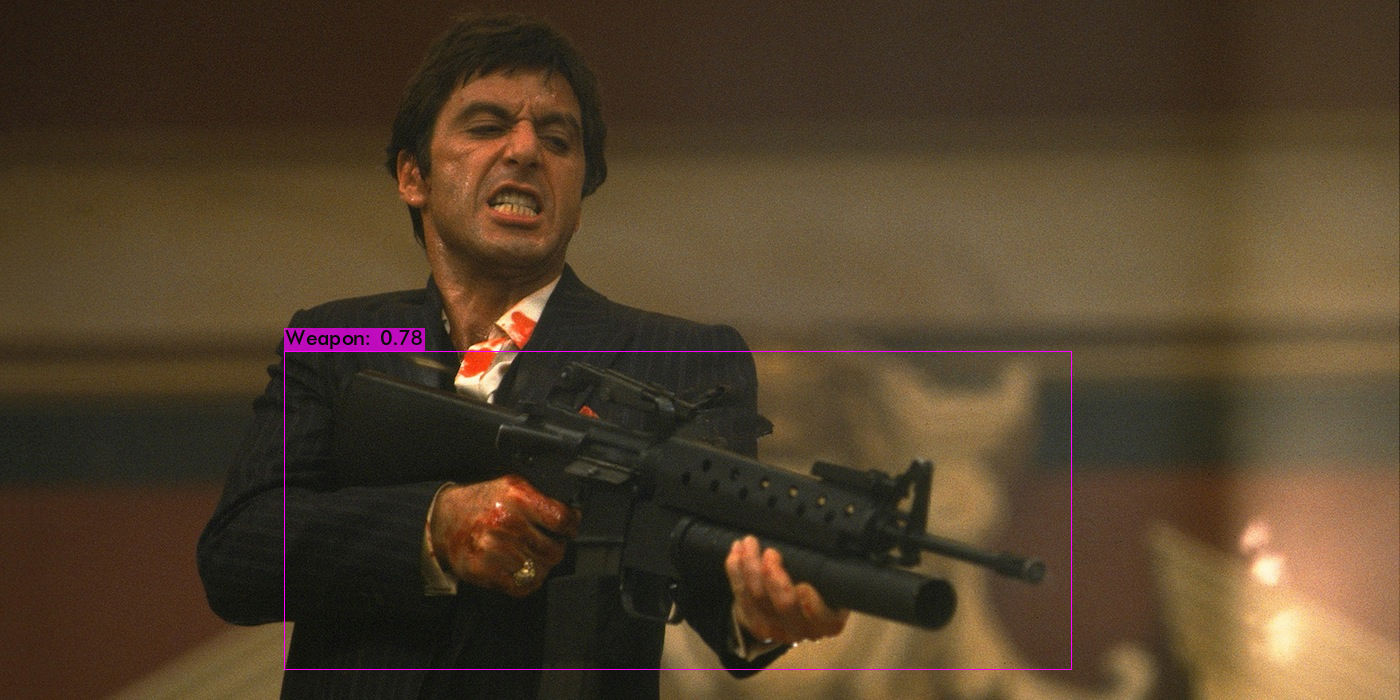

In [ ]:
img

### Video detection

In [ ]:
cd darknet

/content/darknet


In [ ]:
!./darknet detector demo data/obj.data cfg/yolov7_custom.cfg /content/gdrive/MyDrive/weapon_detection/yolov7_custom_best.weights /content/gdrive/MyDrive/validation/weapon-validation-video.mp4 -out_filename /content/darknet/res.mp4 -dont_show

 CUDA-version: 11080 (12000), cuDNN: 8.9.0, GPU count: 1  
 OpenCV version: 4.2.0
Demo
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 64, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    640 x 640 x   3 ->  640 x 640 x  32 0.708 BF
   1 conv     64       3 x 3/ 2    640 x 640 x  32 ->  320 x 320 x  64 3.775 BF
   2 conv     64       3 x 3/ 1    320 x 320 x  64 ->  320 x 320 x  64 7.550 BF
   3 conv    128       3 x 3/ 2    320 x 320 x  64 ->  160 x 160 x 128 3.775 BF
   4 conv     64       1 x 1/ 1    160 x 160 x 128 ->  160 x 160 x  64 0.419 BF
   5 route  3 		                           ->  160 x 160 x 128 
   6 conv     64       1 x 1/ 1    160 x 160 x 128 ->  160 x 160 x  64 0.419 BF
   7 conv     64       3 x 3/ 1    160 x 160 x  64 ->  160 x 160 x  64 1.887 BF
   8 conv     64       3 x 3/ 

In [ ]:
cd ..

/content


In [ ]:
def weapon_video_detection(video_path):

    output_video_path = f"{DARKNET_DIR}/res.avi"

    command = [
        os.path.join(DARKNET_DIR, "darknet"),
        "detector",
        "demo",
        WEAPON_MODEL_META_PATH,
        WEAPON_MODEL_CONFIG_PATH,
        WEAPON_MODEL_WEIGHTS_PATH,
        "-out_filename",
        output_video_path,
        "-dont_show"
    ]

    result = subprocess.run(command, capture_output=True, text=True, cwd=DARKNET_DIR)

    return "success"

In [ ]:
video_path = "/content/gdrive/MyDrive/validation/weapon-validation-video.mp4"
weapon_video_detection(video_path)

In [ ]:
play_video("/content/darknet/res.mp4")

Output hidden; open in https://colab.research.google.com to view.

### On Webcam

In [ ]:
#cd darknet

In [ ]:
#!./darknet detector demo data/obj.data cfg/yolov7_custom.cfg /content/gdrive/MyDrive/weapon_detection/yolov7_custom_best.weights

In [ ]:
#cd ..

## MobileNet Bi-LSTM to detect violence

In [ ]:
# Loading the archutecture
with open(VIOLENCE_MODEL_ARCHITECTURE_PATH, "r") as json_file:
    MoBiLSTM_model_json = json_file.read()

# Loading the model
MoBiLSTM_model = model_from_json(MoBiLSTM_model_json)

# Loading the weights
MoBiLSTM_model.load_weights(VIOLENCE_MODEL_WEIGHTS_PATH)

### Video

In [ ]:
def predict_video(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Declare a list to store video frames we will extract.
    frames_list = []

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Get the number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    # Iterating the number of times equal to the fixed length of sequence.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list
        frames_list.append(normalized_frame)

    # Passing the  pre-processed frames to the model and get the predicted probabilities.
    predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    # Get the index of class with highest probability.
    predicted_label = np.argmax(predicted_labels_probabilities)

    # Get the class name using the retrieved index.
    predicted_class_name = CLASSES_LIST[predicted_label]

    # Display the predicted class along with the prediction confidence.
    print(f'Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
# Specifying video to be predicted
input_video_file_path = "/content/gdrive/MyDrive/validation/violence-validation-video.mp4"

# Perform Single Prediction on the Test Video.
predict_video(input_video_file_path, SEQUENCE_LENGTH)

# Play the actual video
play_video(input_video_file_path)

Output hidden; open in https://colab.research.google.com to view.

### Frame by frame

In [51]:
def predict_frames(video_file_path, output_file_path, SEQUENCE_LENGTH):

    # Read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # VideoWriter to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'),
                                    video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Store the predicted class in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # We Need at Least number of SEQUENCE_LENGTH Frames to perform a prediction.
        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        if predicted_class_name == "Violence":
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255),  10)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0),  10)

        # Write The frame into the disk using the VideoWriter
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [52]:
plt.style.use("seaborn-v0_8-dark")

# To show Random Frames from the saved output predicted video (output predicted video doesn't show on the notebook but can be downloaded)
def show_pred_frames(pred_video_path):
    plt.figure(figsize=(20,13))

    video_reader = cv2.VideoCapture(pred_video_path)

    # Get the number of frames in the video.
    frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Get Random Frames from the video then Sort it
    random_range = sorted(random.sample(range (SEQUENCE_LENGTH , frames_count ), 12))

    num_rows = 3
    num_cols = 4

    for counter, random_index in enumerate(random_range, 1):
        plt.subplot(num_rows, num_cols, counter)

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, random_index)

        ok, frame = video_reader.read()

        if not ok:
          break

        frame = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)

        plt.imshow(frame)

    plt.tight_layout(w_pad=0.001, h_pad=0.1)  # width and height between images

    video_reader.release()

In [53]:
# Construct the output video path.
test_videos_directory = 'test_video'
os.makedirs(test_videos_directory, exist_ok = True)

output_video_file_path = f'{test_videos_directory}/Output-Test-Video.mp4'

In [54]:
# Specifying video to be predicted
input_video_file_path = "/content/gdrive/MyDrive/validation/violence-validation-video.mp4"

# Perform Prediction on the Test Video.
predict_frames(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

# Show random frames from the output video
show_pred_frames(output_video_file_path)

## Both models inference

In [ ]:
def process_video(video_file_path, output_file_path, threshold=0.5):
    # Video properties
    original_video_width = None
    original_video_height = None
    fps = None

    # Initialize video reader
    video_reader = cv2.VideoCapture(video_file_path)

    # Get video properties
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    # Initialize video writer
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('m', 'p', '4', 'v'), fps,
                                   (original_video_width, original_video_height))

    # Initialize frame queue
    frames_queue = deque(maxlen=16)

    # Initialize result variables
    detected_frames = []
    sequence_frames = []
    sequence_labels = []

    # Process video frames
    while video_reader.isOpened():
        # Read frame
        ret, frame = video_reader.read()

        if not ret:
            break

        # Perform weapon detection on the frame
        img = weapon_image_detection(frame, threshold)

        # Perform violence classification on the frame
        # Resize the frame to fixed dimensions
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Normalize the frame
        normalized_frame = resized_frame / 255
        # Add the frame to the queue
        frames_queue.append(normalized_frame)

        # Check if we have enough frames to make a prediction
        if len(frames_queue) == 16:
            # Convert frames queue to a numpy array
            sequence_frames = np.array(frames_queue)
            # Perform violence classification using bi-LSTM model
            predicted_labels_probabilities = MoBiLSTM_model.predict(np.expand_dims(sequence_frames, axis=0))[0]
            # Get the predicted label
            predicted_label = np.argmax(predicted_labels_probabilities)
            # Get the class name using the predicted label
            predicted_class_name = CLASSES_LIST[predicted_label]

            # Store the sequence of frames and its label if violence is detected
            if predicted_class_name == "Violence":
                sequence_frames = sequence_frames * 255  # Convert frames back to 0-255 range
                sequence_labels.append((sequence_frames, predicted_class_name))

        # Write the frame with the corresponding label
        if img is not None:
            detected_frames.append(img)
            cv2.putText(frame, "Weapon Detected", (5, 100), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (0, 0, 255), 12)
        else:
            cv2.putText(frame, predicted_class_name, (5, 100), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.5, (0, 255, 0), 12)

        video_writer.write(frame)

    # Release video reader and writer
    video_reader.release()
    video_writer.release()

    # Return the detected frames and the sequences with violence frames
    return detected_frames, sequence_labels


In [ ]:
video_file_path = ""
output_file_path = ""

process_video(video_file_path, output_file_path)